# Autoencoder -- Image compressor

The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [8]:
import pandas as pd
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model
import tensorflow.keras as keras
from keras.callbacks import EarlyStopping
import cv2
import numpy as np
import tensorflow as tf

In [2]:
import tensorflow as tf
print(f"cuDNN Version: {tf.sysconfig.get_build_info()['cudnn_version']}")
print(f"CUDA Version: {tf.sysconfig.get_build_info()['cuda_version']}")

cuDNN Version: 9
CUDA Version: 12.5.1


In [9]:
outfits_df = pd.read_csv('../Datasets/outfits_training.csv')

### Process

In this section, the first step is to train each category of clothing that we have. The purpose of this is to generate a different model for each type of clothing category, ensuring that the model can generalize each garment effectively. Additionally, this approach provides advantages due to the nature of an autoencoder:

1. Dimensionality reduction
2. Extraction of the most important features from the images


This is crucial because we are dealing with images. An interesting point to mention is that autoencoders are often used in images to remove noise and preserve only the most important features.

In [10]:
def prepare_images(image_path):
    print(image_path)
    nparr = cv2.imread(image_path, cv2.IMREAD_COLOR)
    im = cv2.resize(nparr, (64,64))
    im = im/255
    return im

In [11]:
display(outfits_df.head())
print(len(outfits_df))

,Outfit,likes,19,25,28,261,21,237,49,17,...,11,24,7,241,9,8,26,240,263,236
0,199683429,14,../Images/199683429/1.jpg,../Images/199683429/2.jpg,../Images/199683429/3.jpg,../Images/199683429/4.jpg,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,122754559,8,NaN,../Images/122754559/2.jpg,NaN,NaN,../Images/122754559/1.jpg,../Images/122754559/3.jpg,../Images/122754559/4.jpg,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,208049788,452,NaN,NaN,NaN,NaN,../Images/208049788/1.jpg,NaN,../Images/208049788/4.jpg,../Images/208049788/2.jpg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,171294961,25,NaN,NaN,NaN,../Images/171294961/4.jpg,NaN,../Images/171294961/3.jpg,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,203338168,16,NaN,../Images/203338168/2.jpg,NaN,NaN,../Images/203338168/1.jpg,../Images/203338168/3.jpg,../Images/203338168/4.jpg,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


120


### Building the Autoencoder

Since this is a convolutional autoencoder, its architecture consists of convolutional layers and a pooling layer, which in this case will be max pooling. Max pooling works by selecting the maximum value from a grid of the original matrix.

Essentially, this results in the reduction of the feature map created by the convolutional operation. For this reason, when applying the convolutional layer, its padding should remain unchanged, so that after applying the operation, the matrix retains its size. Then, max pooling is applied to perform the reduction; in this case, the stride is set to 2x2.

The number of layers to be used in the autoencoder is 14 layers.

Subsequently, the data is flattened, transitioning to the fully condensed (or reduced) layer.

In [12]:
import pickle

In [13]:
list_clothes = outfits_df.columns[2:]
weights = []

for clothing in list_clothes:
    
    # Creating the encoder and decoder
    input_layer = Input(shape=(64, 64, 3)) # there are 3 channels

    # Encoder / compressing
    conv1 = Conv2D(496, (3,3), activation='relu', padding='same')(input_layer) # we are using 496 filters (randomly) and a filter of 3x3
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = Conv2D(248, (3,3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = Conv2D(124, (3,3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

    conv4 = Conv2D(64, (3,3), activation='relu', padding='same')(pool3)
    pool4 = MaxPooling2D(pool_size=(2,2))(conv4)

    conv5 = Conv2D(32, (3,3), activation='relu', padding='same')(pool4)
    pool5 = MaxPooling2D((2,2), padding='same')(conv5)

    conv6 = Conv2D(16, (3,3), activation='relu', padding='same')(pool5)
    pool6 = MaxPooling2D((2,2), padding='same')(conv6)

    conv7 = Conv2D(16, (3,3), activation='relu', padding='same')(pool6)
    pool7 = MaxPooling2D((2,2), padding='same')(conv7)

    encoded = Flatten(name = 'encoded')(pool7) # Layer embedded

    ## Decoder / uncompress, returning the original form    --- Basically this is the mirror of the encoder
    conv8 = Conv2D(16, (3,3), activation='relu', padding='same')(pool7)
    up1 = UpSampling2D((2,2))(conv8)

    conv9 = Conv2D(16, (3,3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2,2))(conv9)

    conv10 = Conv2D(32, (3,3), activation='relu', padding='same')(up2)
    up3 = UpSampling2D((2,2))(conv10)

    conv11 = Conv2D(64, (3,3), activation='relu', padding='same')(up3)
    up4 = UpSampling2D((2,2))(conv11)

    conv12 = Conv2D(128, (3,3), activation='relu', padding='same')(up4)
    up5 = UpSampling2D((2,2))(conv12)

    conv13 = Conv2D(248, (3,3), activation='relu', padding='same')(up5)
    up6 = UpSampling2D((1,1))(conv13)

    conv14 = Conv2D(496, (3,3), activation='relu', padding='same')(up6)
    up7 = UpSampling2D((2,2))(conv14)

    decoded = Conv2D(3,(1,1), activation='sigmoid', padding='same')(up7)

    # Creating the autoencoder
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    encoder = Model(input_layer, encoded)

    # Fit the model created
    features = []
    for i in range(len(outfits_df[clothing])):
        if not pd.isna(outfits_df[clothing][i]):
            features.append(prepare_images( outfits_df[clothing][i]))
        else:
            nan_array = np.empty((64, 64, 3))
            nan_array.fill(0)
            features.append(nan_array)
    
    # Convert the list of images into a single NumPy array
    x_train = np.array(features)
    print("Tamano del conjunto train:",len(x_train))
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
    autoencoder.fit(x_train, x_train, epochs=20, batch_size=100, validation_split=.15, callbacks=[early_stopping])

    # Savings the weights
    weights = encoder.get_weights()
    
    file_path = "./" + clothing + "_model_weights.pkl"
    with open(file_path, "wb") as w:
        pickle.dump(weights, w)

    del(autoencoder)
    del(encoder)
    keras.backend.clear_session()
    
    


../Images/199683429/1.jpg
../Images/110740725/1.jpg
../Images/209461564/3.jpg
../Images/196202215/1.jpg
../Images/216332732/2.jpg
../Images/214175215/2.jpg
../Images/154754035/1.jpg
../Images/200664553/1.jpg
../Images/144132157/1.jpg
../Images/213771157/1.jpg
../Images/211044817/1.jpg
../Images/174053567/2.jpg
../Images/184907475/4.jpg
../Images/216336193/1.jpg
../Images/192481909/1.jpg
../Images/213122862/1.jpg
../Images/213962289/2.jpg
../Images/216262892/1.jpg
../Images/101311946/4.jpg
../Images/179108235/1.jpg
../Images/211292942/1.jpg
../Images/185744352/3.jpg
../Images/213837982/1.jpg
../Images/214478949/2.jpg
../Images/216093717/1.jpg
Tamano del conjunto train: 120
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 919ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 382ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 378ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 387ms/step - loss: 0.6931 - 

## Multiple input - Cnn

Ahora, ya tenemos un modelo para cada categoria de ropa. Lo siguiente es pasar todas las entradas como una sola a la Cnn, para esto se tendrá que tener en cuenta que cada capa será concatenada al final. No obstante, en nuestro caso se concatena la salida del autoencoder.

In [15]:
def load_autoencoder_weights(input_dim, weight_file):
    input_layer = Input(shape=(64, 64, 3))  # la entrada debe coincidir con la forma de las imágenes

    # Encoder (compresión)
    conv1 = Conv2D(496, (3,3), activation='relu', padding='same')(input_layer)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = Conv2D(248, (3,3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = Conv2D(124, (3,3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

    conv4 = Conv2D(64, (3,3), activation='relu', padding='same')(pool3)
    pool4 = MaxPooling2D(pool_size=(2,2))(conv4)

    conv5 = Conv2D(32, (3,3), activation='relu', padding='same')(pool4)
    pool5 = MaxPooling2D((2,2), padding='same')(conv5)

    conv6 = Conv2D(16, (3,3), activation='relu', padding='same')(pool5)
    pool6 = MaxPooling2D((2,2), padding='same')(conv6)

    conv7 = Conv2D(16, (3,3), activation='relu', padding='same')(pool6)
    pool7 = MaxPooling2D((2,2), padding='same')(conv7)

    encoded = Flatten(name = 'encoded')(pool7)  # Capa de codificación

    # Crear el modelo solo para el encoder
    encoder = Model(input_layer, encoded)
    return encoder

**Extracting the shapes**

In [30]:
input_shapes = {}
inputs_encoded_array = []
for clothing in list_clothes:
    features = []
    for i in range(len(outfits_df[clothing])):
        if not pd.isna(outfits_df[clothing][i]):
            features.append(prepare_images(outfits_df[clothing][i]))
        else:
            nan_array = np.empty((64, 64, 3))
            nan_array.fill(np.nan)
            features.append(nan_array)

    # Convert the list of images into a single NumPy array
    x_train = np.array(features)
    name = "./" + clothing + "_model_weights.pkl"
    encoder = load_autoencoder_weights(x_train, name)
    encoded_features = encoder.predict(x_train)

    input_shapes[clothing] = (encoded_features.shape[1],)
    inputs_encoded_array.append(encoded_features)

../Images/199683429/1.jpg
../Images/110740725/1.jpg
../Images/209461564/3.jpg
../Images/196202215/1.jpg
../Images/216332732/2.jpg
../Images/214175215/2.jpg
../Images/154754035/1.jpg
../Images/200664553/1.jpg
../Images/144132157/1.jpg
../Images/213771157/1.jpg
../Images/211044817/1.jpg
../Images/174053567/2.jpg
../Images/184907475/4.jpg
../Images/216336193/1.jpg
../Images/192481909/1.jpg
../Images/213122862/1.jpg
../Images/213962289/2.jpg
../Images/216262892/1.jpg
../Images/101311946/4.jpg
../Images/179108235/1.jpg
../Images/211292942/1.jpg
../Images/185744352/3.jpg
../Images/213837982/1.jpg
../Images/214478949/2.jpg
../Images/216093717/1.jpg
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step
../Images/199683429/2.jpg
../Images/122754559/2.jpg
../Images/203338168/2.jpg
../Images/206706910/2.jpg
../Images/110740725/7.jpg
../Images/214625379/2.jpg
../Images/184841489/2.jpg
../Images/189741381/2.jpg
../Images/215898147/2.jpg
../Images/216888986/2.jpg
../Images/182850881/4.jpg
../Images/196202215/5.jpg

Based on API keras

        # define two sets of inputs
        inputA = Input(shape=(32,))
        inputB = Input(shape=(128,))
        # the first branch operates on the first input
        x = Dense(8, activation="relu")(inputA)
        x = Dense(4, activation="relu")(x)
        x = Model(inputs=inputA, outputs=x)
        # the second branch opreates on the second input
        y = Dense(64, activation="relu")(inputB)
        y = Dense(32, activation="relu")(y)
        y = Dense(4, activation="relu")(y)
        y = Model(inputs=inputB, outputs=y)
        # combine the output of the two branches
        combined = concatenate([x.output, y.output])
        # apply a FC layer and then a regression prediction on the
        # combined outputs
        z = Dense(2, activation="relu")(combined)
        z = Dense(1, activation="linear")(z)
        # our model will accept the inputs of the two branches and
        # then output a single value
        model = Model(inputs=[x.input, y.input], outputs=z)

<details>    
<summary>
    <font size="3" color="pink"><b>Categories</b></font>
</summary>
<p>
- '19'
- '25'
- '28'
- '261'
- '21'
- '237'
- '49'
- '17'
- '27'
- '104'
- '18'
- '4'
- '5'
- '2'
- '4495'
- '41'
- '29'
- '4496'
- '11'
- '24'
- '7'
- '241'
- '9'
- '8'
- '26'
- '240'
- '263'
- '236'


In [44]:
input_shapes.keys()

dict_keys(['19', '25', '28', '261', '21', '237', '49', '17', '27', '104', '18', '4', '2', '4495', '41', '29', '4496', '11', '24', '7', '241', '9', '8', '26', '240', '263', '236'])

In [22]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from tensorflow.keras.layers import concatenate
import numpy as np
from keras import Input, Model

array_shapes = ['19', '25', '28', '261', '21', '237', '49', '17', '27', '104', '18', '4', '2', '4495', '41', '29', '4496', '11', '24', '7', '241', '9', '8', '26', '240', '263', '236']
model = Sequential()
inputs_array = []
categories = outfits_df.columns[2:]

# Creating the inputs
for index in array_shapes:
    inputs_array.append( Input(shape=input_shapes[index], name=index) )


# Creating the dense layer
layers_array = []
for i, index in enumerate(array_shapes):
    layers_array.append( Dense(32, activation='relu', name=f'output_{index}')(inputs_array[i]) )

**You get the second layers which are going to be used to create the first fully connected layer.
layer of fully connected. Subsequently the results will be concatenated.**

In [24]:
layer2_array = []

for i, index in enumerate(array_shapes):
    layer2_array.append( Dense(32, activation='relu')(layers_array[i]) )
    layer2_array[-1] = Model(inputs=inputs_array[i], outputs=layer2_array[-1])

## Mixed the input, concatenate the all inputs

In [26]:
## OUTPUT
output_array = []
for i, index in enumerate(array_shapes):
    output_array.append(layer2_array[i].output)

layers_concatenated = concatenate(output_array)

z = Dense(4, activation='relu')(layers_concatenated)
z = Dense(1, activation='linear')(z)


## INPUT
input_array = []
for i, index in enumerate(array_shapes):
    input_array.append(layer2_array[i].input)

model = Model(inputs=input_array, outputs=z)

### Compiling the model

In [27]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

model.compile(loss='mse', optimizer=optimizer, metrics=['mean_absolute_error'])

## Training the model

In [33]:
target = []
for i in outfits_df['likes']:
    target.append(i)

inputs_encoded_array = np.array(inputs_encoded_array)
target = np.array(np.log(target))

# These input are encoded --> inputs_array.append(encoded_features)
model.fit(x=[inputs_encoded_array[0],
             inputs_encoded_array[1],
             inputs_encoded_array[2],
             inputs_encoded_array[3],
             inputs_encoded_array[4],
             inputs_encoded_array[5],
             inputs_encoded_array[6],
             inputs_encoded_array[7],
             inputs_encoded_array[8],
             inputs_encoded_array[9],
             inputs_encoded_array[10],
             inputs_encoded_array[11],
             inputs_encoded_array[12],
             inputs_encoded_array[13],
             inputs_encoded_array[14],
             inputs_encoded_array[15],
             inputs_encoded_array[16],
             inputs_encoded_array[17],
             inputs_encoded_array[18],
             inputs_encoded_array[19],
             inputs_encoded_array[20],
             inputs_encoded_array[21],
             inputs_encoded_array[22],
             inputs_encoded_array[23],
             inputs_encoded_array[24],
             inputs_encoded_array[25],
             inputs_encoded_array[26]], y=target, epochs=10)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 14.6213 - mean_absolute_error: 3.4561
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 13.8233 - mean_absolute_error: 3.3544
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 13.1746 - mean_absolute_error: 3.2595
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 11.5507 - mean_absolute_error: 2.9915
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 10.2784 - mean_absolute_error: 2.7836
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.7357 - mean_absolute_error: 2.4912
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.7030 - mean_absolute_error: 2.1164
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.4555 - mean_absolute_error: 1.8396
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.0587 - mean_absolute_error: 1.5251
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.8431 - mean_absolute_error: 1.2663


## Testing the model

In [34]:
import json
import pandas as pd

# Loading the dataset
train_path = '../Datasets/test_no_dup.json'
with open(train_path) as file:
  df_test = json.load(file)

In [35]:
numbers_list = [
    2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 15, 17, 18, 19, 21, 23, 24, 25, 26, 27, 28, 29, 
    41, 49, 52, 104, 236, 237, 238, 239, 241, 
    244, 245, 247, 252, 253, 254, 255, 256, 257, 261, 262, 263, 264, 309, 
    4517, 4518, 4241, 240, 241, 250, 251, 4495, 4496
]

category_numbers = [3, 23, 41, 7, 11, 27, 25]
womens_fashion_test = []

for outfit in df_test:
    outfit_categories = {item['categoryid'] for item in outfit['items']}
    if outfit_categories.issubset(numbers_list) and len(outfit_categories)>= 3:
        womens_fashion_test.append(outfit)

print(len(womens_fashion_test))
womens_fashion_test

33


[{'name': 'Hello I am Back !!',
  'views': 3425,
  'items': [{'index': 1,
    'name': 'wang pattern loose black sweatshirt',
    'price': 16.0,
    'likes': 1228,
    'image': 'http://img2.polyvoreimg.com/cgi/img-thing?.out=jpg&size=m&tid=127962646',
    'categoryid': 4495},
   {'index': 2,
    'name': 'single button tweed coat',
    'price': 23.0,
    'likes': 15009,
    'image': 'http://img2.polyvoreimg.com/cgi/img-thing?.out=jpg&size=m&tid=127403877',
    'categoryid': 24},
   {'index': 3,
    'name': 'pockets ripped denim shorts',
    'price': 15.0,
    'likes': 5305,
    'image': 'http://img2.polyvoreimg.com/cgi/img-thing?.out=jpg&size=m&tid=127423615',
    'categoryid': 29},
   {'index': 4,
    'name': 'self-tie platform black shoes',
    'price': 50.0,
    'likes': 10,
    'image': 'http://img2.polyvoreimg.com/cgi/img-thing?.out=jpg&size=m&tid=128317447',
    'categoryid': 41}],
  'image': 'http://ak2.polyvoreimg.com/cgi/img-set/cid/146775141/id/7MnZvFSg5BGD3VDrh-Oa4g/size/y.jpg

In [37]:
import os

def buscar_directorio(nombre_directorio, ruta_carpeta):
    for root, dirs, files in os.walk(ruta_carpeta):
        if nombre_directorio in dirs:
            ruta_completa = os.path.join(root, nombre_directorio)
            return ruta_completa

route = "../Images"
# Dataset limited
for i in range(len(womens_fashion_test)):
    id_outfit = womens_fashion_test[i]['set_id']
    dir_searched = str(id_outfit)
    route_relative = buscar_directorio(dir_searched, route)
    for j in range(len(womens_fashion_test[i]['items'])):
        number = womens_fashion_test[i]['items'][j]['index']
        route_complete = str(route_relative).replace("\\","/")+'/'+str(number)+'.jpg'
        # Substitution
        womens_fashion_test[i]['items'][j]['image'] = route_complete


womens_fashion_test

[{'name': 'Hello I am Back !!',
  'views': 3425,
  'items': [{'index': 1,
    'name': 'wang pattern loose black sweatshirt',
    'price': 16.0,
    'likes': 1228,
    'image': '../Images/146775141/1.jpg',
    'categoryid': 4495},
   {'index': 2,
    'name': 'single button tweed coat',
    'price': 23.0,
    'likes': 15009,
    'image': '../Images/146775141/2.jpg',
    'categoryid': 24},
   {'index': 3,
    'name': 'pockets ripped denim shorts',
    'price': 15.0,
    'likes': 5305,
    'image': '../Images/146775141/3.jpg',
    'categoryid': 29},
   {'index': 4,
    'name': 'self-tie platform black shoes',
    'price': 50.0,
    'likes': 10,
    'image': '../Images/146775141/4.jpg',
    'categoryid': 41}],
  'image': 'http://ak2.polyvoreimg.com/cgi/img-set/cid/146775141/id/7MnZvFSg5BGD3VDrh-Oa4g/size/y.jpg',
  'likes': 104,
  'date': 'Two years',
  'set_url': 'http://www.polyvore.com/hello_am_back/set?id=146775141',
  'set_id': '146775141',
  'desc': 'Sweatshirt by #romwe :\nhttp://www.

### Creating the dataframe for testing 

In [81]:
# Functions
def get_routes_images(df_json):
    number_outfits = len(df_json)
    
    df_fashion = pd.DataFrame(columns=['Outfit','likes'])

    for i in range(number_outfits):
        df_fashion.loc[i, 'Outfit'] = df_json[i]['set_id']
        for j in range(len(df_json[i]['items'])):    
            df_fashion.loc[i, str(df_json[i]['items'][j]['categoryid'])] = df_json[i]['items'][j]['image']
        
        df_fashion.loc[i, 'likes'] = df_json[i]['likes']
        
    return df_fashion

outfits_df_test = get_routes_images(womens_fashion_test)
display(outfits_df_test)

,Outfit,likes,4495,24,29,41,11,25,49,27,...,6,5,9,241,257,4,15,52,252,255
0,146775141,104,../Images/146775141/1.jpg,../Images/146775141/2.jpg,../Images/146775141/3.jpg,../Images/146775141/4.jpg,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,195655851,36,NaN,NaN,../Images/195655851/3.jpg,NaN,../Images/195655851/1.jpg,../Images/195655851/2.jpg,../Images/195655851/4.jpg,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,187286174,5,NaN,NaN,NaN,../Images/187286174/4.jpg,../Images/187286174/3.jpg,../Images/187286174/1.jpg,NaN,../Images/187286174/2.jpg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,109560851,99,NaN,../Images/109560851/4.jpg,NaN,../Images/109560851/3.jpg,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,191561256,221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,203295275,53,NaN,NaN,NaN,NaN,NaN,../Images/203295275/1.jpg,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,215989339,50,NaN,NaN,NaN,../Images/215989339/4.jpg,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,146794904,24,NaN,../Images/146794904/4.jpg,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,216455223,196,NaN,../Images/216455223/2.jpg,../Images/216455223/3.jpg,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,179530906,460,NaN,../Images/179530906/2.jpg,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Extracting just the outfits**

In [51]:
columns_to_keep = [col for col in outfits_df_test.columns if col in input_shapes.keys()]
filtered_outfits_df_test = outfits_df_test[columns_to_keep]
for key in input_shapes.keys():
    if key not in filtered_outfits_df_test.columns:
        filtered_outfits_df_test[key] = np.NaN
filtered_outfits_df_test.head()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_9388\3805278076.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_outfits_df_test[key] = np.NaN
C:\Users\Usuario\AppData\Local\Temp\ipykernel_9388\3805278076.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_outfits_df_test[key] = np.NaN
C:\Users\Usuario\AppData\Local\Temp\ipykernel_9388\3805278076.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

,4495,24,29,41,11,25,49,27,19,240,...,28,263,104,237,9,241,4,18,26,236
0,../Images/146775141/1.jpg,../Images/146775141/2.jpg,../Images/146775141/3.jpg,../Images/146775141/4.jpg,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,../Images/195655851/3.jpg,NaN,../Images/195655851/1.jpg,../Images/195655851/2.jpg,../Images/195655851/4.jpg,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,../Images/187286174/4.jpg,../Images/187286174/3.jpg,../Images/187286174/1.jpg,NaN,../Images/187286174/2.jpg,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,../Images/109560851/4.jpg,NaN,../Images/109560851/3.jpg,NaN,NaN,NaN,NaN,../Images/109560851/1.jpg,../Images/109560851/2.jpg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Recommendations

In [53]:
inputs_test_array = []

list_clothes = filtered_outfits_df_test.columns

for clothing in list_clothes:
    features = []
    for i in range(len(filtered_outfits_df_test[clothing])):
        if not pd.isna(filtered_outfits_df_test[clothing][i]):
            features.append(prepare_images(filtered_outfits_df_test[clothing][i]))
        else:
            nan_array = np.empty((64, 64, 3))
            nan_array.fill(0)
            features.append(nan_array)

    # Convert the list of images into a single NumPy array
    x_test = np.array(features)
    # input_shapes[clothing] = (x_train.shape[1],x_train.shape[2],x_train.shape[3])
    encoded_features_test = encoder.predict(x_test)
    inputs_test_array.append(encoded_features_test)

../Images/146775141/1.jpg
../Images/100077218/1.jpg
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 
../Images/146775141/2.jpg
../Images/109560851/4.jpg
../Images/146794904/4.jpg
../Images/216455223/2.jpg
../Images/179530906/2.jpg
../Images/213129288/2.jpg
../Images/211429965/2.jpg
../Images/109470169/4.jpg
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step 
../Images/146775141/3.jpg
../Images/195655851/3.jpg
../Images/216455223/3.jpg
../Images/114497631/5.jpg
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step 
../Images/146775141/4.jpg
../Images/187286174/4.jpg
../Images/109560851/3.jpg
../Images/215989339/4.jpg
../Images/206715568/5.jpg
../Images/111358675/4.jpg
../Images/215438471/3.jpg
../Images/172524167/8.jpg
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 
../Images/195655851/1.jpg
../Images/187286174/3.jpg
../Images/211260731/7.jpg
../Images/109470169/2.jpg
../Images/196309780/8.jpg
../Images/147736951/1.jpg
../Images/159191469/1.jpg
../Images/215438471/1.jpg
../Images/100077218/4.jpg
../Images/172524167/2.jpg
2/2 ━━━━━━━━

In [56]:


inputs_test_array = np.array(inputs_test_array)
print(len(inputs_test_array))

predictions = model.predict([
             inputs_test_array[0],
             inputs_test_array[1],
             inputs_test_array[2],
             inputs_test_array[3],
             inputs_test_array[4],
             inputs_test_array[5],
             inputs_test_array[6],
             inputs_test_array[7],
             inputs_test_array[8],
             inputs_test_array[9],
             inputs_test_array[10],
             inputs_test_array[11],
             inputs_test_array[12],
             inputs_test_array[13],
             inputs_test_array[14],
             inputs_test_array[15],
             inputs_test_array[16],
             inputs_test_array[17],
             inputs_test_array[18],
             inputs_test_array[19],
             inputs_test_array[20],
             inputs_test_array[21],
             inputs_test_array[22],
             inputs_test_array[23],
             inputs_test_array[24],
             inputs_test_array[25],
             inputs_test_array[26]]).flatten()

# Print predictions
print(predictions.shape)

27
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
(33,)


In [57]:
print(predictions)

[3.2817607 3.2508998 3.2456849 3.2485027 3.245357  3.2344508 3.2322161
 3.26298   3.2698455 3.2614295 3.2438798 3.233409  3.233409  3.2184863
 3.2369356 3.2389646 3.2478087 3.231522  3.2474031 3.249609  3.2352757
 3.2439127 3.2213674 3.2503476 3.2465398 3.2336318 3.2315764 3.2394013
 3.2270646 3.2786944 3.2457314 3.2577016 3.218485 ]


### Showing the recommendation

In [78]:
predictions_series = pd.Series(predictions)

filtered_outfits_df_test['likes_predicted'] = predictions_series
filtered_outfits_df_test['likes_predicted'] = filtered_outfits_df_test['likes_predicted'].astype(float)
display(filtered_outfits_df_test)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_9388\1429163655.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_outfits_df_test['likes_predicted'] = predictions_series
C:\Users\Usuario\AppData\Local\Temp\ipykernel_9388\1429163655.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_outfits_df_test['likes_predicted'] = filtered_outfits_df_test['likes_predicted'].astype(float)


,4495,24,29,41,11,25,49,27,19,240,...,263,104,237,9,241,4,18,26,236,likes_predicted
0,../Images/146775141/1.jpg,../Images/146775141/2.jpg,../Images/146775141/3.jpg,../Images/146775141/4.jpg,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.281761
1,NaN,NaN,../Images/195655851/3.jpg,NaN,../Images/195655851/1.jpg,../Images/195655851/2.jpg,../Images/195655851/4.jpg,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.250900
2,NaN,NaN,NaN,../Images/187286174/4.jpg,../Images/187286174/3.jpg,../Images/187286174/1.jpg,NaN,../Images/187286174/2.jpg,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.245685
3,NaN,../Images/109560851/4.jpg,NaN,../Images/109560851/3.jpg,NaN,NaN,NaN,NaN,../Images/109560851/1.jpg,../Images/109560851/2.jpg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.248503
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.245357
5,NaN,NaN,NaN,NaN,NaN,../Images/203295275/1.jpg,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.234451
6,NaN,NaN,NaN,../Images/215989339/4.jpg,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.232216
7,NaN,../Images/146794904/4.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.262980
8,NaN,../Images/216455223/2.jpg,../Images/216455223/3.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.269845
9,NaN,../Images/179530906/2.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,../Images/179530906/4.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.261430


In [79]:
from matplotlib import pyplot as plt

def show_image(image_path):
    print(image_path)
    nparr = cv2.imread(image_path, cv2.IMREAD_COLOR)
    plt.figure(figsize=(2, 2))
    plt.imshow(nparr)
    plt.axis('off')  # Para deshabilitar los ejes
    plt.show()
    return

### Outfit recommended based on your closet ###
../Images/146775141/1.jpg


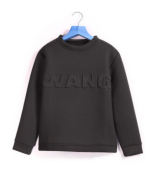

../Images/146775141/2.jpg


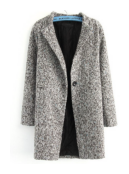

../Images/146775141/3.jpg


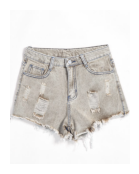

../Images/146775141/4.jpg


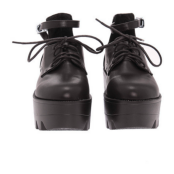

In [83]:
outfit_selected = filtered_outfits_df_test[filtered_outfits_df_test['likes_predicted'] == filtered_outfits_df_test['likes_predicted'].max()]
columns = outfit_selected.columns[:-1]

cloths = filtered_outfits_df_test.columns
flag = False

print("### Outfit recommended based on your closet ###")
for c in cloths[:-1]:
    if not pd.isna(outfit_selected[c].iloc[0]):
        if c in predictions:
            flag = True
            break
        show_image(outfit_selected[c].iloc[0])